In [1]:
%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }<\style>"))
import argparse
import os
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from PIL import Image
import tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.nn.functional import one_hot as one_hot
import torch.utils.data as data
import utils
from model import * 


In [4]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 1 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
#         negative_mask[i, i + batch_size] = 0
#     negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def triplet(out_1,out_2,tau_plus,batch_size,temperature, debias = True):
    N = batch_size * 2 - 2
    out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
    s = torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2).sum(-1) # 2 * bs x 2 * bs
    mask = get_negative_mask(batch_size).to(device)
    
    if debias:
        s = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

        neg = (-tau_plus * N * pos + s.sum(-1)) / (1 - tau_plus)

    else:
        neg = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

    return (pos - neg).mean()

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
#     difficulty by cosine similarity
    s_d = torch.exp(torch.mm(out_d, out_d.t().contiguous()) / temperature)
    s_d = s_d.masked_select(mask).view(1 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_d = F.normalize(s_d, dim = -1)
    
    s_b = torch.exp(torch.mm(out_b, out_b.t().contiguous()) / temperature)
    s_b = s_b.masked_select(mask).view(1 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_b = F.normalize(s_b, dim = -1)
    
    weight = 1 + s_d / (s_b + s_d + 1e-6)
#     print(weight)
    if np.isnan(weight.sum().item()):
        print('weight NaN')
        
    return weight.detach()

def criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, temperature):
    # neg score
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    
    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)

    # negative samples similarity scoring
    N = batch_size * 2 - 2
#         imp = (beta* neg.log()).exp()
#         reweight_neg = (imp*neg).sum(dim = -1) / imp.mean(dim = -1)
    reweight_neg = weight * neg

    Ng = (-tau_plus * N * pos + reweight_neg.sum(dim = -1)) / (1 - tau_plus)
    # constrain (optional)
    Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))

    # contrastive loss
    loss = (-torch.log(pos / (pos + Ng) )).mean()

    return loss

In [5]:
batch_size = 128
device = 'cuda:0'
tau_plus = 0.1
dataset_name = 'cub'
beta =0.9
estimator = 'hard'
temperature =0.7
epochs = 400



In [6]:
model_d = Image_Model().cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/cub_model_d_256_0.1_0.3_0.001_100.pth')))
model_d.eval();

model_b = Image_Model().cuda()
model_b = nn.DataParallel(model_b)
model_b.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/cub_model_b_256_0.1_0.3_0.001_100.pth')))
model_b.eval();


In [7]:
train_data, memory_data, test_data = utils.get_dataset('cub', root='../data', pair = False)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

k = 200
c = len(memory_data.classes)

In [8]:
'''
y = 0: landbird
y = 1: waterbird

s = 0: land background
s = 1: water background


class = 0 landbird on land
class = 1 landbird on water
class = 2 waterbird on land
class = 3 waterbird on water
'''


'\ny = 0: landbird\ny = 1: waterbird\n\ns = 0: land background\ns = 1: water background\n\n\nclass = 0 landbird on land\nclass = 1 landbird on water\nclass = 2 waterbird on land\nclass = 3 waterbird on water\n'

In [8]:
out_lst = list()
out_b_lst = list()
class_id_lst = list()
Anchor_dict = dict()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature_d, out = model_d(x)
        feature_b, out_b = model_b(x)

        out_lst.append(out)
        out_b_lst.append(out_b)
        class_id_lst.append(class_id)
        
    out_lst = torch.cat(out_lst)
    out_b_lst = torch.cat(out_b_lst)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(out_b_lst)
    weight = W(out_lst, out_b_lst, bs) # (bs, bs - 1)

    for i, cls_id in enumerate(class_id_lst):
        cls_id = cls_id.item()
        if cls_id not in Anchor_dict.keys():
            Anchor_dict[cls_id] = {'N':[], 'N_class':[], 'P':[]}

        cls_idx = class_id_lst == cls_id
        mask = torch.ones((bs,), dtype=bool).cuda()
        mask[i] = 0
        cls_idx = cls_idx.masked_select(mask)

        Anchor_dict[cls_id]['N'].append(weight[i][~cls_idx].detach().cpu())
        Anchor_dict[cls_id]['N_class'].append(class_id_lst.masked_select(mask)[~cls_idx].detach().cpu())
        Anchor_dict[cls_id]['P'].append(weight[i][cls_idx].detach().cpu())

for key in Anchor_dict.keys():
    Anchor_dict[key]['N'] = torch.cat(Anchor_dict[key]['N']).numpy()
    Anchor_dict[key]['N_class'] = torch.cat(Anchor_dict[key]['N_class']).numpy()
    Anchor_dict[key]['P'] = torch.cat(Anchor_dict[key]['P']).numpy()

In [11]:
cls_dict = {0:'landbird on land (LoL)', 1:'landbird on water (LoW)', 2:'waterbird on land (WoL)', 3:'waterbird on water (WoW)'}

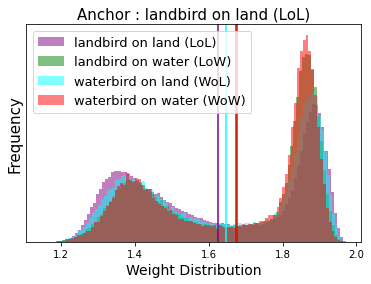

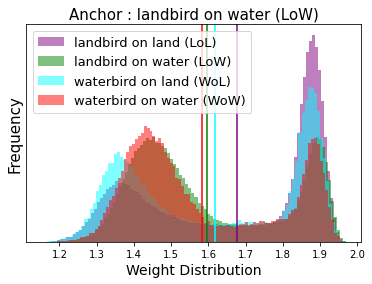

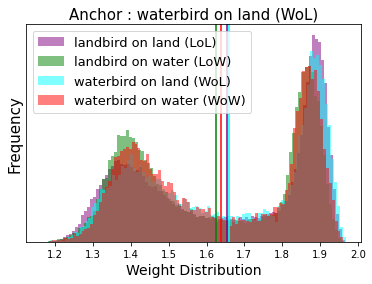

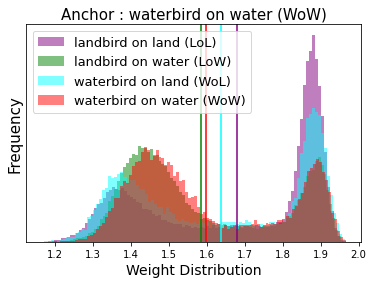

In [22]:
anchor_idx = 2
colors = ['purple', 'green', 'cyan', 'red']
# colors = ['aqua', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'cyan', 'yellow', 'lime']


for anchor_idx in range(4):
    plt.figure(figsize = (6,4))
    for i in range(4):
        if i != anchor_idx:
            plt.hist(Anchor_dict[anchor_idx]['N'][Anchor_dict[anchor_idx]['N_class'] == i], bins = 100, alpha = 0.5, density = True, label = cls_dict[i] , color = colors[i])
            plt.axvline(Anchor_dict[anchor_idx]['N'][Anchor_dict[anchor_idx]['N_class'] == i].mean(), c = colors[i])
        else:
            plt.hist(Anchor_dict[anchor_idx]['P'], bins = 100, alpha = 0.5, density = True, label = cls_dict[i] , color = colors[i])
            plt.axvline(Anchor_dict[anchor_idx]['P'].mean(), c = colors[i])
    
#     plt.xlim(0.0)
    plt.legend(fontsize = 13)
    plt.xlabel('Weight Distribution', fontsize = 14)
    plt.ylabel('Frequency', fontsize = 15)
    plt.yticks([])
    plt.title('Anchor : {}'.format(cls_dict[anchor_idx]), fontsize = 15)
    plt.savefig('figures/illust/weight_CUB_{}.pdf'.format(anchor_idx), bbox_inches = 'tight')
    plt.show()

In [15]:
Anchor_dict[anchor_idx]['N'][Anchor_dict[anchor_idx]['N_class'] == 0].mean()

1.6804302

In [14]:
'''
y = 0: landbird
y = 1: waterbird

s = 0: land background
s = 1: water background


class = 0 landbird on land
class = 1 landbird on water
class = 2 waterbird on land
class = 3 waterbird on water
'''


'\ny = 0: landbird\ny = 1: waterbird\n\ns = 0: land background\ns = 1: water background\n\n\nclass = 0 landbird on land\nclass = 1 landbird on water\nclass = 2 waterbird on land\nclass = 3 waterbird on water\n'

In [15]:
'''anchor 1, 3

for landbird on water --> hard sampels: landbird on land, waterbird on land


'''


'anchor 1, 3\n\nfor landbird on water --> hard sampels: landbird on land, waterbird on land\n\n\n'

## Cosine Similarity

In [136]:
#HCL
model_d = Image_Model().cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'hcl', 'cub_hard_model_256_0.3_1.0_400.pth')))
model_d.eval();

# # #DCL
# model_d = Image_Model().cuda()
# model_d = nn.DataParallel(model_d)
# model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'dcl', 'model_400.pth')))
# model_d.eval();

In [105]:
feature_lst = list()
class_id_lst = list()
Anchor_dict = dict()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst = torch.cat(feature_lst)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst)


In [106]:
cs_list = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst[class_id_lst == i], feature_lst[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list.append(cs_diag)
cs_list = torch.cat(cs_list).numpy()

n_cs_list = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst[class_id_lst == i], feature_lst[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list.append(cs_diag)
n_cs_list = torch.cat(n_cs_list).numpy()

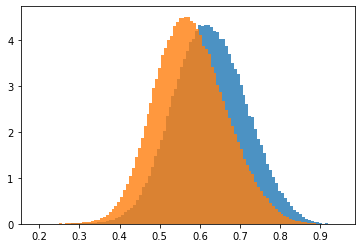

In [109]:
plt.hist(cs_list, bins = 100, alpha = 0.8, density = True);
plt.hist(n_cs_list, bins = 100, alpha = 0.8, density = True);

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


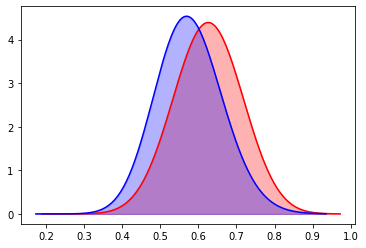

In [128]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

ax = sns.distplot(cs_list, fit_kws={"color":"red"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(n_cs_list, fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="label 2");

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="blue", alpha=0.3)

plt.show(block=False)

#### DCL

In [131]:
feature_lst_dcl = list()
class_id_lst = list()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst_dcl.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst_dcl = torch.cat(feature_lst_dcl)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst_dcl)


cs_list_dcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_dcl[class_id_lst == i], feature_lst_dcl[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list_dcl.append(cs_diag)
cs_list_dcl = torch.cat(cs_list_dcl).numpy()

n_cs_list_dcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_dcl[class_id_lst == i], feature_lst_dcl[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list_dcl.append(cs_diag)
n_cs_list_dcl = torch.cat(n_cs_list_dcl).numpy()

#### HCL

In [137]:
feature_lst_hcl = list()
class_id_lst = list()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst_hcl.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst_hcl = torch.cat(feature_lst_hcl)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst_hcl)


cs_list_hcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_hcl[class_id_lst == i], feature_lst_hcl[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list_hcl.append(cs_diag)
cs_list_hcl = torch.cat(cs_list_hcl).numpy()

n_cs_list_hcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_hcl[class_id_lst == i], feature_lst_hcl[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list_hcl.append(cs_diag)
n_cs_list_hcl = torch.cat(n_cs_list_hcl).numpy()

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

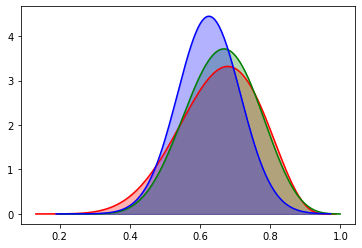

In [139]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

ax = sns.distplot(cs_list_dcl, fit_kws={"color":"red"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(cs_list_hcl, fit_kws={"color":"green"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(cs_list, fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="label 2");

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="green", alpha=0.3)
ax.fill_between(x3,y3, color="blue", alpha=0.3)

plt.show(block=False)

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

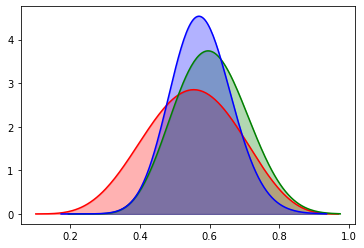

In [140]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

ax = sns.distplot(n_cs_list_dcl, fit_kws={"color":"red"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(n_cs_list_hcl, fit_kws={"color":"green"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(n_cs_list, fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="label 2");

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="green", alpha=0.3)
ax.fill_between(x3,y3, color="blue", alpha=0.3)

plt.show(block=False)